In [13]:
# set tf 1.x for colab
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() #to use older versions of tensorflow 1.x


Instructions for updating:
non-resource variables are not supported in the long term


# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
#import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
#import grading

import matplotlib
from importlib import reload
reload(matplotlib)

#import grading_utils
#reload(grading_utils)


#from keras.utils import reset_tf_session

We're using TF 2.10.0


<module 'matplotlib' from 'C:\\Users\\user\\anaconda3\\lib\\site-packages\\matplotlib\\__init__.py'>

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [24]:
s=tf.Session()

In [16]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


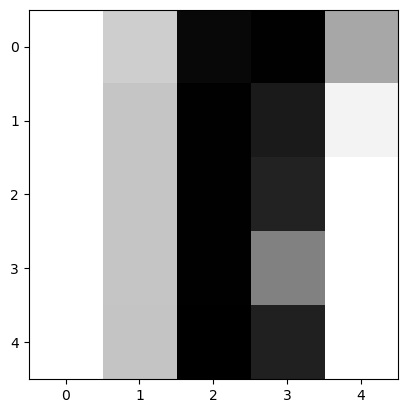

And the whole sample:


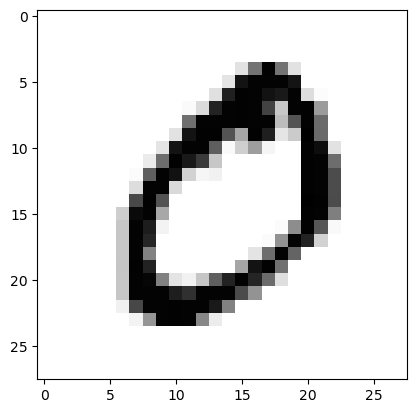

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [17]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [18]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [19]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [ ]:
# run this again if you remake your graph
s = reset_tf_session()

In [ ]:
# Model parameters: W and b
W = tf.get_variable(shape=(784,10), name = 'Weights')
b = tf.get_variable(shape=(10,),name = 'Bias')

In [21]:
# Placeholders for the input data
input_X = tf.placeholder('float32',shape=(None,784))
input_y = tf.placeholder('float32',shape=(None,10)) 

In [25]:
# Compute predictions
logits = input_X @ W + b
probas = tf.nn.softmax(logits)
classes = tf.argmax(probas, axis=1) 

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y, logits=logits))

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer().minimize(loss)# optimizer step that minimizes the loss

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [33]:
import matplotlib_utils

In [34]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiuG%2BM/wC0/wDs1fs4R2M37Q/7Q/gbwEmqOU01vGni2z0sXbDGREbmVPMIyMhc9RWV4z/bY/Y0%2BHOnz6t8Qf2tvhloVra6fY39zcax480%2B2SK1vVkaznZpJgBHOsUpic/LII3KFtpwAenUV5/4n/ax/ZZ8EfFOy%2BBnjT9pb4f6R421IxjTvB2qeMrG31W6MmPL8u0klEz7sjbtU5zxUvxo/aj/AGZf2bxYt%2B0R%2B0X4E8BDVGYaafGni6y0v7WVwCIvtMqeZjIztzjIoA7uiuC%2BIP7VX7L/AMJPAWlfFT4q/tIeAvDPhfXERtE8SeIfGFlZWGoK6h1MFxNKscoKkMCrHIORxXS%2BAfiF4B%2BK3hCx%2BIPwu8caP4k0DU4zJpuuaBqcV5Z3aBihaKaFmSQBlZSVJ5UjtQBsUVxfxn/aQ/Z3/Zx0yz1v9ob49eC/AdlqExhsLvxn4ptNLiuZBjKRvcyIHYZHAJPIq3r3xy%2BCnhXw3oXjLxR8YPC2m6P4ovILTw1qt/4gtobbVrieNpIYbWV3CzvJGjuioWLKjEAgE0AdTRXli/tsfsn6v8GfFvx78B/tH%2BAfE3hfwTZTz%2BI9a0HxpYXNnYNFGzmOe4jlaOBjjGHI61wP7JX/AAVb/Yh/ay/Zs0/9o3RP2jfh9okK%2BGrDV/GGhaj8QNNa58Ii7KpHDqW2bFq/msIv3gTL/KOeKAPpGivOk/bB/ZKk0bxT4jT9qL4dnTvA90lr411AeNbDyNAnYkLFeyebttXJVgFlKk4PFX/DX7S/7OPjT4SX3x%2B8HftAeCdW8CaZbT3GpeNdM8V2c%2BkWkMK75pJbxJDDGka/M7M4Cjk4FAHbUVwPgf8Aar/Ze%2BJvxCufhH8Nv2kfAPiHxXZWoubzwxofjCyu9RghIB817aKVpFTDKdxUDDD1rf8AC3xX%2BFvjjw1f%2BM/BXxJ0DWNH0u8u7TU9W0vWYLi2tLi1do7qGWWNisbwujrIrEFGRgwBBoA36KzPBfjXwb8SPCWm%2BP8A4d%2BLdM1/QdZso7zSNb0W/jurS%2Bt5FDJNDNEzJLGykEMpIIOQa06ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorznQ/2wf2SfE3xVk%2BBPhv9qT4c6h43imeKXwbY%2BN7CXVUkTO9DaLKZgy7WyNuRg56VofGf9pb9nL9nCxs9U/aH%2BP/AIJ8BW2oymLT7nxp4qs9LjunGMrG1zIgcjIyFyeRQB21FcZ4y/aO/Z5%2BHXwxtvjZ8Qfjx4M0LwZexxPZ%2BLtZ8UWlrpk6yLujZLqWRYmDAEqQxyORmmeHP2l/2cfGHh/w74s8JftAeCdU0rxhqp0zwlqeneK7Oe31u%2BEckhtbSRJCtzMEhlfy4yzbYnOMKSADtqK5/Uviz8K9G8Vah4F1f4l%2BH7TW9J8Prr2qaNc6zBHdWelF5IxfyxM4eO2LwzIJmATdE43ZU45Xw/8AtmfsgeLL640zwr%2B1X8N9TubPwxH4ku4NP8cWEzwaM6xMmpOEmJS0YTwlZziMiVCGO4ZAPSqK4f4M/tN/s2/tGw31x%2Bz1%2B0H4H8eR6Y6pqT%2BDPFlnqgtGbO0Sm2kfyydrYDYzg%2BlU/EX7Xn7J3hD4r23wH8WftP8Aw70vxzeSxxWngzUfGthBq07yY8tUtHlEzFsjaAuTkY60AeiUVieEPiZ8OPiDZanqXgL4gaJrltourXWl6zcaRqsNylhfWzbLi1maNiIpom%2BV42wyHhgDUngL4geA/ir4O074ifC/xtpHiTw/q9sLjSdd0DUoryzvYT0khmhZkkU4PzKSOKANeiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACimT3EFrH51zOkaAgF3YAZJwOT71H/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AfnPf/Ez9ln9lT/grR%2B0H8R/%2BCkkuiaAvjbRvC6fBPxt4%2B0zzNMm0GDTfKvtLsrqVGit5l1AzyzW25ZJfPik2uMbb37Knww/Zm%2BM3/BZ34r/FPw98OPD%2BqaLpv7N3w%2BHgFptARILHTb19UYCC3ljX7OGihhULsVlQFMAEiv0K/tPTf%2BgjB/3%2BX/Gj%2B09N/wCgjB/3%2BX/GgD8YdS8W/sc/DX9hD9qH9j/9sX4fQX/7TnjHxx44ePwxe%2BFZbrxF4z1S9vLlvD1/pJETSXEIiksBDLCdlv5JJ8vaa9O/aHHgP9m74meAfjV8XP2%2Bfhl4E/aF0/8AZ28O%2BGfHXhT46eApNe0jxD9nWWd2tZ45YJ453upboSG0lmL4j3QlgpP6of2npv8A0EYP%2B/y/40f2npv/AEEYP%2B/y/wCNAH5XfFT4ofBrxz4H/Zs/bX%2BL/wAZfAv7KPxbtfhNew6P8Pfit8OzqnhcafezQGWBIJTaG0lL2kTRmGaO5WGbYyMDg/Qn7HfxW/bv/ak/Yp8FfEz9nrQvg58H7x9Z12DV7HXvhfq17pOuW8d/Iltq2l20eoadNaW93iW6xcCR3Fwpz1eT7N/

# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [35]:
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.
logits= tf.layers.dense(input_X,784,activation=tf.nn.sigmoid)
hidden1=tf.layers.dense(logits,256,activation=tf.nn.sigmoid)
hidden2=tf.layers.dense(hidden1,256,activation=tf.nn.sigmoid)
output=tf.layers.dense(hidden2,10)

probas= tf.nn.softmax(output)
classes=tf.argmax(probas,axis=1)

loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y,logits=output))
step=tf.train.AdamOptimizer().minimize(loss)

C:\Users\user\AppData\Local\Temp/ipykernel_10956/1613818218.py:3: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits= tf.layers.dense(input_X,784,activation=tf.nn.sigmoid)
C:\Users\user\AppData\Local\Temp/ipykernel_10956/1613818218.py:4: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hidden1=tf.layers.dense(logits,256,activation=tf.nn.sigmoid)
C:\Users\user\AppData\Local\Temp/ipykernel_10956/1613818218.py:5: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  hidden2=tf.layers.dense(hidden1,256,activation=tf.nn.sigmoid)
C:\Users\user\AppData\Local\Temp/ipykernel_10956/1613818218.py:6: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  output=tf.layers.dense(

In [36]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiuG%2BM/wC0/wDs1fs4R2M37Q/7Q/gbwEmqOU01vGni2z0sXbDGREbmVPMIyMhc9RWV4z/bY/Y0%2BHOnz6t8Qf2tvhloVra6fY39zcax480%2B2SK1vVkaznZpJgBHOsUpic/LII3KFtpwAenUV5/4n/ax/ZZ8EfFOy%2BBnjT9pb4f6R421IxjTvB2qeMrG31W6MmPL8u0klEz7sjbtU5zxUvxo/aj/AGZf2bxYt%2B0R%2B0X4E8BDVGYaafGni6y0v7WVwCIvtMqeZjIztzjIoA7uiuC%2BIP7VX7L/AMJPAWlfFT4q/tIeAvDPhfXERtE8SeIfGFlZWGoK6h1MFxNKscoKkMCrHIORxXS%2BAfiF4B%2BK3hCx%2BIPwu8caP4k0DU4zJpuuaBqcV5Z3aBihaKaFmSQBlZSVJ5UjtQBsUVxfxn/aQ/Z3/Zx0yz1v9ob49eC/AdlqExhsLvxn4ptNLiuZBjKRvcyIHYZHAJPIq3r3xy%2BCnhXw3oXjLxR8YPC2m6P4ovILTw1qt/4gtobbVrieNpIYbWV3CzvJGjuioWLKjEAgE0AdTRXli/tsfsn6v8GfFvx78B/tH%2BAfE3hfwTZTz%2BI9a0HxpYXNnYNFGzmOe4jlaOBjjGHI61wP7JX/AAVb/Yh/ay/Zs0/9o3RP2jfh9okK%2BGrDV/GGhaj8QNNa58Ii7KpHDqW2bFq/msIv3gTL/KOeKAPpGivOk/bB/ZKk0bxT4jT9qL4dnTvA90lr411AeNbDyNAnYkLFeyebttXJVgFlKk4PFX/DX7S/7OPjT4SX3x%2B8HftAeCdW8CaZbT3GpeNdM8V2c%2BkWkMK75pJbxJDDGka/M7M4Cjk4FAHbUVwPgf8Aar/Ze%2BJvxCufhH8Nv2kfAPiHxXZWoubzwxofjCyu9RghIB817aKVpFTDKdxUDDD1rf8AC3xX%2BFvjjw1f%2BM/BXxJ0DWNH0u8u7TU9W0vWYLi2tLi1do7qGWWNisbwujrIrEFGRgwBBoA36KzPBfjXwb8SPCWm%2BP8A4d%2BLdM1/QdZso7zSNb0W/jurS%2Bt5FDJNDNEzJLGykEMpIIOQa06ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorznQ/2wf2SfE3xVk%2BBPhv9qT4c6h43imeKXwbY%2BN7CXVUkTO9DaLKZgy7WyNuRg56VofGf9pb9nL9nCxs9U/aH%2BP/AIJ8BW2oymLT7nxp4qs9LjunGMrG1zIgcjIyFyeRQB21FcZ4y/aO/Z5%2BHXwxtvjZ8Qfjx4M0LwZexxPZ%2BLtZ8UWlrpk6yLujZLqWRYmDAEqQxyORmmeHP2l/2cfGHh/w74s8JftAeCdU0rxhqp0zwlqeneK7Oe31u%2BEckhtbSRJCtzMEhlfy4yzbYnOMKSADtqK5/Uviz8K9G8Vah4F1f4l%2BH7TW9J8Prr2qaNc6zBHdWelF5IxfyxM4eO2LwzIJmATdE43ZU45Xw/8AtmfsgeLL640zwr%2B1X8N9TubPwxH4ku4NP8cWEzwaM6xMmpOEmJS0YTwlZziMiVCGO4ZAPSqK4f4M/tN/s2/tGw31x%2Bz1%2B0H4H8eR6Y6pqT%2BDPFlnqgtGbO0Sm2kfyydrYDYzg%2BlU/EX7Xn7J3hD4r23wH8WftP8Aw70vxzeSxxWngzUfGthBq07yY8tUtHlEzFsjaAuTkY60AeiUVieEPiZ8OPiDZanqXgL4gaJrltourXWl6zcaRqsNylhfWzbLi1maNiIpom%2BV42wyHhgDUngL4geA/ir4O074ifC/xtpHiTw/q9sLjSdd0DUoryzvYT0khmhZkkU4PzKSOKANeiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACimT3EFrH51zOkaAgF3YAZJwOT71H/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AT0VB/aem/wDQRg/7/L/jR/aem/8AQRg/7/L/AI0AfnPf/Ez9ln9lT/grR%2B0H8R/%2BCkkuiaAvjbRvC6fBPxt4%2B0zzNMm0GDTfKvtLsrqVGit5l1AzyzW25ZJfPik2uMbb37Knww/Zm%2BM3/BZ34r/FPw98OPD%2BqaLpv7N3w%2BHgFptARILHTb19UYCC3ljX7OGihhULsVlQFMAEiv0K/tPTf%2BgjB/3%2BX/Gj%2B09N/wCgjB/3%2BX/GgD8YdS8W/sc/DX9hD9qH9j/9sX4fQX/7TnjHxx44ePwxe%2BFZbrxF4z1S9vLlvD1/pJETSXEIiksBDLCdlv5JJ8vaa9O/aHHgP9m74meAfjV8XP2%2Bfhl4E/aF0/8AZ28O%2BGfHXhT46eApNe0jxD9nWWd2tZ45YJ453upboSG0lmL4j3QlgpP6of2npv8A0EYP%2B/y/40f2npv/AEEYP%2B/y/wCNAH5XfFT4ofBrxz4H/Zs/bX%2BL/wAZfAv7KPxbtfhNew6P8Pfit8OzqnhcafezQGWBIJTaG0lL2kTRmGaO5WGbYyMDg/Qn7HfxW/bv/ak/Yp8FfEz9nrQvg58H7x9Z12DV7HXvhfq17pOuW8d/Iltq2l20eoadNaW93iW6xcCR3Fwpz1eT7N/

final validation accuracy: 0.98